# B+Tree索引原理

B+树是从最早的平衡二叉树演化而来的。二叉查找树->平衡二叉树（AVLTree）->平衡多路查找树（B-Tree）-> B+树

## 二叉查找树
二叉树具有以下性质：左子树的键值小于根的键值，右子树的键值大于根的键值。
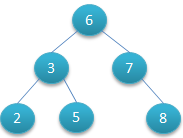

二叉查找树可以任意地构造，同样是2,3,5,6,7,8这六个数字，也可以按照下图的方式来构造：

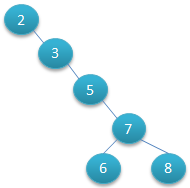
但是这棵二叉树的查询效率就低了。因此若想二叉树的查询效率尽可能高，需要这棵二叉树是平衡的，从而引出新的定义——平衡二叉树，或称AVL树。

## 平衡二叉树（AVL Tree）

平衡二叉树（AVL树）在符合二叉查找树的条件下，还满足任何节点的两个子树的高度最大差为1。下面的两张图片，左边是AVL树，它的任何节点的两个子树的高度差<=1；右边的不是AVL树，其根节点的左子树高度为3，而右子树高度为1


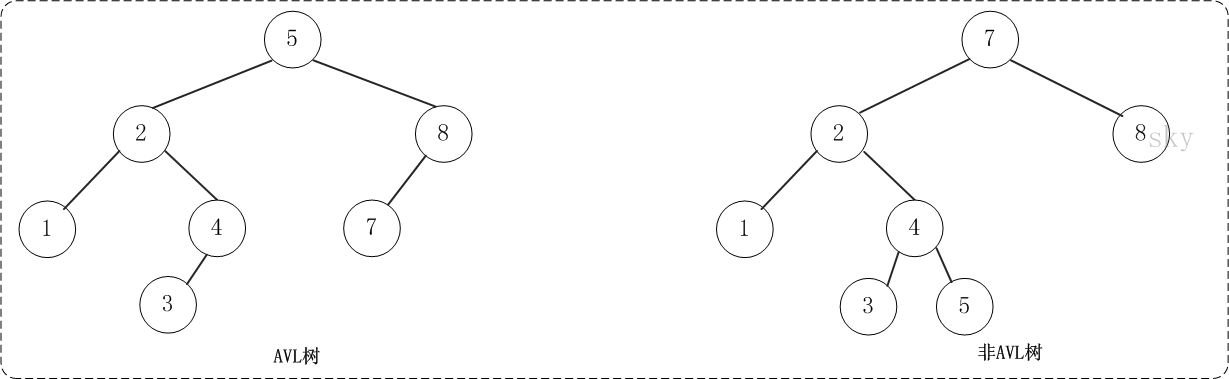
如果在AVL树中进行插入或删除节点，可能导致AVL树失去平衡。这时可以通过左旋和又旋来自动调整这棵树，使其变得平衡。

## 平衡多路查找树

B-Tree是为磁盘等外存储设备设计的一种平衡查找树。涉及到磁盘相关，那么了解一下磁盘的一些简单的内容:系统从磁盘读取数据到内存时是以磁盘块（block）为基本单位的，位于同一个磁盘块中的数据会被一次性读取出来，而不是需要什么取什么。

InnoDB存储引擎中有页（Page）的概念，页是其磁盘管理的最小单位。InnoDB存储引擎中默认每个页的大小为16KB，可通过参数innodb_page_size将页的大小设置为4K、8K、16K，在MySQL中可通过如下命令查看页的大小：show variables like 'innodb_page_size';

系统一个磁盘块的存储空间往往没有这么大，因此InnoDB每次申请磁盘空间时都会是若干地址连续磁盘块来达到页的大小16KB。InnoDB在把磁盘数据读入到磁盘时会以页为基本单位，在查询数据时如果一个页中的每条数据都能有助于定位数据记录的位置，这将会减少磁盘I/O次数，提高查询效率。

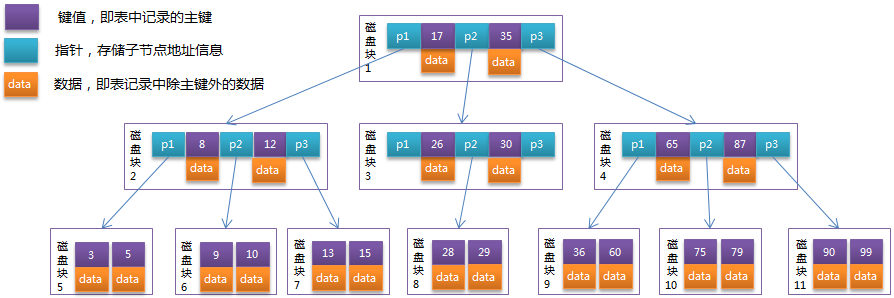

B-Tree 树的key和data是绑定在一起的。

<font color="red">每个节点</font>占用一个盘块的磁盘空间，一个节点上有两个升序排序的关键字和三个指向子树根节点的指针，指针存储的是子节点所在磁盘块的地址。两个关键词划分成的三个范围域对应三个指针指向的子树的数据的范围域。以根节点为例，关键字为17和35，P1指针指向的子树的数据范围为小于17，P2指针指向的子树的数据范围为17~35，P3指针指向的子树的数据范围为大于35。

模拟查找关键字29的过程：

1. 根据根节点找到磁盘块1，读入内存。【磁盘I/O操作第1次】:比较关键字29在区间（17,35），找到磁盘块1的指针P2。
2. 根据P2指针找到磁盘块3，读入内存。【磁盘I/O操作第2次】:比较关键字29在区间（26,30），找到磁盘块3的指针P2。
3. 根据P2指针找到磁盘块8，读入内存。【磁盘I/O操作第3次】: 在磁盘块8中的关键字列表中找到关键字29。

分析上面过程，发现需要3次磁盘I/O操作，和3次内存查找操作。由于内存中的关键字是一个有序表结构，可以利用二分法查找提高效率。而3次磁盘I/O操作是影响整个B-Tree查找效率的决定因素。B-Tree相对于AVLTree缩减了节点个数(一个节点不再是放单纯的一个数, 可以放多个key)，使每次磁盘I/O取到内存的数据都发挥了作用，从而提高了查询效率。

## B+Tree

B+Tree是在B-Tree基础上的一种优化，使其更适合实现外存储索引结构，InnoDB存储引擎就是用B+Tree实现其索引结构。

从B-Tree结构图中可以看到每个节点中不仅包含数据的key值，还有data值。而每一个页的存储空间是有限的，如果data数据较大时将会导致每个节点（即一个页）能存储的key的数量很小，当存储的数据量很大时同样会导致B-Tree的深度较大，增大查询时的磁盘I/O次数，进而影响查询效率。在B+Tree中，<font color="red">所有数据记录节点都是按照键值大小顺序存放在同一层的叶子节点上，</font>而非叶子节点上只存储key值信息，这样可以大大<font color="red">加大每个节点存储的key值数量，降低B+Tree的高度。</font>

B+Tree相对于B-Tree有几点不同：
1. 非叶子节点只存储键值信息。
2. 所有叶子节点之间都有一个链指针。(用于范围查询)
3. 数据记录都存放在叶子节点中。

由于B+Tree的非叶子节点只存储键值信息，假设每个磁盘块能存储4个键值及指针信息，则变成B+Tree后其结构如下图所示： 

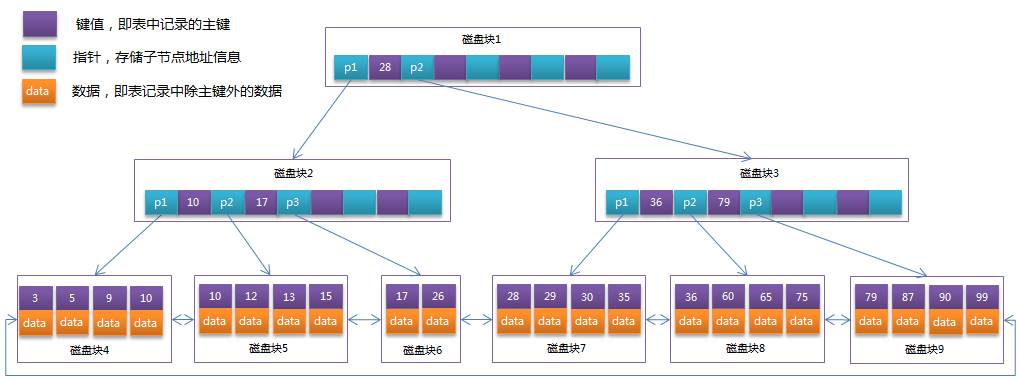

我们发现表的所有记录既然都在最后一层的叶子节点，那么第一层和第二层磁盘块不就存了冗余数据了吗？为了加快查询，这点冗余数据的空间牺牲是值得的。

所有叶子节点（即数据节点）之间是一种链式环结构。因此可以对B+Tree进行两种查找运算：一种是对于主键的范围查找(大于某个数，直接找到这个数，然后沿着链条往下走即可)和分页查找，另一种是从根节点开始，进行随机查找。

下面做一个推算：

InnoDB存储引擎中页的大小为16KB，一般表的主键类型为INT（占用4个字节）或BIGINT（占用8个字节），指针类型也一般为4或8个字节，也就是说一个页（B+Tree中的一个节点）中大概存储16KB/(8B+8B)=1K个键值（因为是估值，为方便计算，这里的K取值为1000）。假设最后一层的data加key大小是1k大小的话，也就是说一个深度为3的B+Tree索引可以维护10^3 * 10^3 * 16 = 1600 万条记录。

实际情况中每个节点可能不能填充满，因此在数据库中，B+Tree的高度一般都在2~4层。mysql的InnoDB存储引擎在设计时是将根节点常驻内存的，也就是说查找某一键值的行记录时最多只需要1~3次磁盘I/O操作。有人可能会问，一个节点存储的数据变多了，那么在这个节点查数据不是变慢了吗？注意，这里我们考虑的是磁盘IO读写，把一个节点的数据加载到内存中去查找比在硬盘查找快的不是一个数量级。

## 聚集索引和辅助索引

B+Tree在数据库中的实现即为聚集索引，聚集索引的B+Tree中的叶子节点存放的是整张表的行记录数据。辅助索引与聚集索引的区别在于辅助索引的叶子节点并不包含行记录的全部数据，而是存储相应行数据的聚集索引键，即主键。当通过辅助索引来查询数据时，InnoDB存储引擎会遍历辅助索引找到主键，然后再通过主键在聚集索引中找到完整的行记录数据。

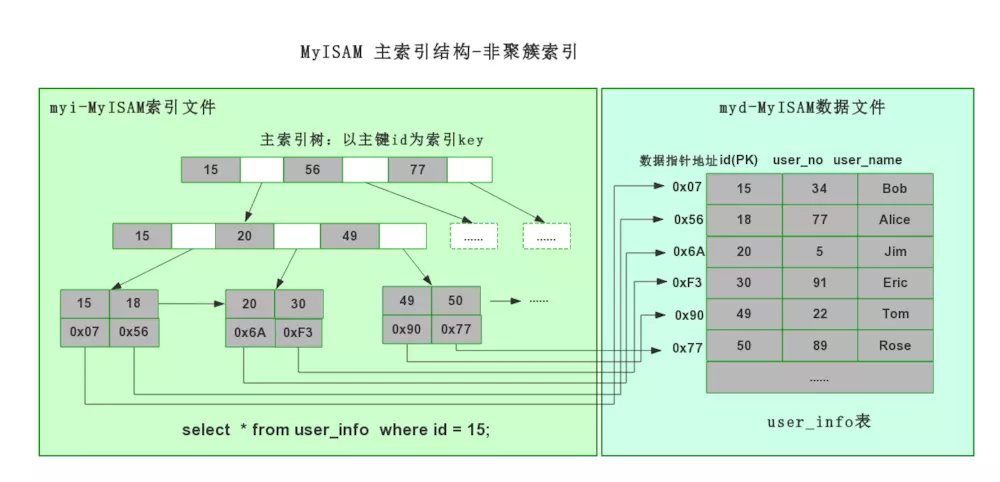
myisam的数据文件和索引文件是分开的，所以对于myisam的一张表总共分为3个部分的文件存储。innodb的数据和索引放在一起，所以innodb的一张表需要2个文件存储(有一个文件描述表的相关信息)。


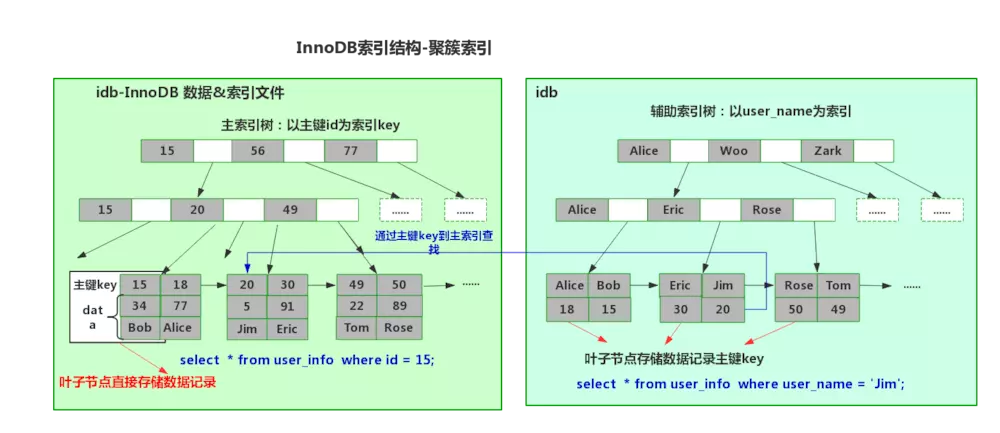